# The DC Motor Example

In this notebook, we'll demonstrate how to use the SimInterface package to build a model of a DC motor connected with an RL circuit. 

The dynamic equations are given by:
\begin{align*}
L\frac{di}{dt} + Ri &= V-K\dot\theta \\
J\ddot \theta + b\theta &= Ki
\end{align*}

First, let's initialize the packages that we'll need. 

In [1]:
import SimInterface as SI
import matplotlib.pyplot as plt
%matplotlib inline

# Setting Parameters



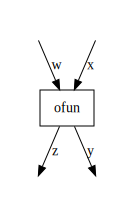

In [1]:

import numpy as np
import numpy.random as rnd
import pandas as pd
import inspect

import graphviz as gv


Time = np.linspace(0,100,1001)

X = SI.Signal(label='x',data=rnd.randn(3,4),shape=4)
X_dot = SI.Signal(label='x_dot',shape=4)
W = SI.Signal(label='w',data=rnd.randn(5,3),shape=3)
V = SI.Signal(label='v',data=rnd.randn(8,5),shape=5)

Y = SI.Signal(label='y',data=rnd.randn(1,2),shape=2)
Z = SI.Signal(label='z',shape=3)

def sfun(x,w):
    return np.zeros(4)

def ofun(x,w):
    return np.zeros(2),np.zeros(3)

# StateFunc = SI.Function(func=sfun,InputVars=(X,W),OutputVars=X_dot,label='sfun')
OutputFunc = SI.StaticFunction(func=ofun,InputVars=(X,W),OutputVars=(Y,Z),label='ofun')
Sys = SI.System(OutputFunc,label='Sys')
Sys.graph

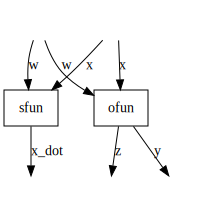

In [2]:
Sys.update([OutputFunc,StateFunc])
Sys.graph